# Recomendacion de restaurantes de Nueva York.


In [1]:
!pip install contextily

In [2]:
#librerias escenciales para el desarrollo
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos los datos desde el drive.

In [4]:
metadata = pd.read_feather('/content/drive/MyDrive/metadata.feather')
reviews = pd.read_feather('/content/drive/MyDrive/reviews.feather')

Volveremos a calcular el rating bayesiano porque nos ayudara en la recomendacion mas adelante.

In [5]:
def bayesian_rating(row, C, m):
    R = row['avg_rating']
    v = row['num_of_reviews']
    return (v / (v + m)) * R + (m / (v + m)) * C

In [6]:
C = metadata['avg_rating'].mean()
m = metadata['num_of_reviews'].quantile(0.5) # Valor umbral, mediana de las reviews

metadata['rating_bayesiano'] = metadata.apply(bayesian_rating, C=C, m=m, axis=1)

In [7]:
metadata.head(2)

,name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,rating_bayesiano
0,Dunkin',0x89c261f60bdf13db:0x38da730e4687a97b,40.763985,-73.771430,"[Coffee shop, Bagel shop, Bakery, Breakfast re...",3.5,8,4.116245
1,李小龍台吃,0x89c289efdb82221b:0xed627c2af97c2069,40.770059,-73.735522,[Restaurant],4.0,27,4.128599


In [8]:
reviews.head(2)

,user_id,name,rating,gmap_id
0,1.018635e+20,Maria Patricia Londoño,4,0x89c261f60bdf13db:0x38da730e4687a97b
1,1.019546e+20,Kristal,5,0x89c261f60bdf13db:0x38da730e4687a97b


## Analisis modelos User KNN e Item KNN

Para poder hacer un estudio menos consumidor, optamos por obtener un sample de 16000 usuarios.

In [9]:
np.random.seed(112)
users = reviews['user_id'].unique()
samp_users = np.random.choice(users, size=16000, replace=False)
samp = reviews[reviews['user_id'].isin(samp_users)] #sample de las reviews en base a los 16000 usuarios

In [10]:
samp.shape

(163906, 4)

Nos quedamos con 163906 reviews provenientes de los 16000 usuarios anteriores.

In [11]:
!pip install surprise

In [12]:
#los modelos vendrand de la libreria surprise
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

Decidimos entrenar los modelos con el 50% del sample en el sentido que el trainset y el testset tendran k/2 reviews por usuario, donde k es la cantidad de reviews de cada usuario. Asi podremos llevar a cabo un testeo mas parejo asegurandonos que hayan reviews en el testset para cada usuario.

In [13]:
def split_user_reviews(user_reviews):
    split_idx = len(user_reviews) // 2
    return user_reviews[:split_idx], user_reviews[split_idx:]

part1 = []
part2 = []

#agrupar por usuario y dividir las reviews
for user_id, reviews in samp.groupby('user_id'):
    reviews = reviews.sample(frac=1).reset_index(drop=True)
    user_part1, user_part2 = split_user_reviews(reviews)
    part1.append(user_part1)
    part2.append(user_part2)

#concatenar las partes para formar los dos nuevos datasets
df_part1 = pd.concat(part1).reset_index(drop=True)
df_part2 = pd.concat(part2).reset_index(drop=True)

In [14]:
df_part1.head(3)

,user_id,name,rating,gmap_id
0,1.000023e+20,Shaliyev Rahim,4,0x89c244410663669b:0xd254800f14acbe14
1,1.000023e+20,Shaliyev Rahim,5,0x89c2446511cf4101:0xdad4fd88a76e1d1d
2,1.000023e+20,Shaliyev Rahim,5,0x89c244653c60f45b:0x43d290db8f85ce2b


In [15]:
df_part2.head(3)

,user_id,name,rating,gmap_id
0,1.000023e+20,Shaliyev Rahim,5,0x89c24479055aa937:0x423bf889b10c440d
1,1.000023e+20,Shaliyev Rahim,4,0x89c2447a553b7957:0x91595c49017b12f
2,1.000023e+20,Shaliyev Rahim,5,0x89c25a4bfd0a2c51:0x426dd9aab1f3b34a


In [16]:
#cargamos la data en el formato requerido para entrenar el modelo KMMBasic

reader = Reader(rating_scale=(1, 5))
data_part1 = Dataset.load_from_df(df_part1[['user_id', 'gmap_id', 'rating']], reader)
data_part2 = Dataset.load_from_df(df_part2[['user_id', 'gmap_id', 'rating']], reader)
trainset = data_part1.build_full_trainset()
testset = data_part2.build_full_trainset().build_testset()

### Vamos a llevar a cabo unas pruebas para comparar distintos parametros en el modelo UserKNN e ItemKNN.

 Definimos primero las funciones que usaremos para el calculo de las metricas Precision@k, Recall@k, MAP@k y NDCG@K.

In [17]:
from collections import defaultdict

1. Precision@k

In [18]:
def precision_at_k(predictions, k, threshold):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k_ratings = user_ratings[:k]
        n_relevant = sum((true_r >= threshold) for (_, true_r) in top_k_ratings)
        precisions.append(n_relevant / k)

    return sum(precisions) / len(precisions)

2. Recall@k

In [19]:
def recall_at_k(predictions, k, threshold):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k_ratings = user_ratings[:k]
        n_relevant = sum((true_r >= threshold) for (_, true_r) in top_k_ratings)
        n_relevant_total = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        recall = n_relevant / n_relevant_total if n_relevant_total != 0 else 0
        recalls.append(recall)

    return sum(recalls) / len(recalls)

3. MAP@k

In [20]:
def mean_average_precision_at_k(predictions, k, threshold):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    map_score = 0.0
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_relevant = 0
        average_precision = 0.0

        for i, (est, true_r) in enumerate(user_ratings[:k], start=1):
            if true_r >= threshold:
                n_relevant += 1
                average_precision += n_relevant / i

        if n_relevant != 0:
            average_precision /= n_relevant
        map_score += average_precision

    return map_score / len(user_est_true)

4. NDCG@k

In [21]:
def dcg_at_k(ratings, k):
    ratings = np.asfarray(ratings)[:k]
    if ratings.size:
        return np.sum(ratings / np.log2(np.arange(2, ratings.size + 2)))
    return 0.0

def ndcg_at_k(predictions, k, threshold):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    ndcg_scores = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        relevance_scores = [(true_r >= threshold) for _, true_r in user_ratings]
        dcg = dcg_at_k(relevance_scores, k)
        ideal_relevance_scores = sorted(relevance_scores, reverse=True)
        idcg = dcg_at_k(ideal_relevance_scores, k)

        ndcg = dcg / idcg if idcg != 0 else 0.0
        ndcg_scores.append(ndcg)

    return sum(ndcg_scores) / len(ndcg_scores)

## UserKNN

#### 1. Cantidad maxima de vecinos k para considerar.



In [22]:
k_values = [1, 2, 3, 4, 5, 6]
mae_values = []
rmse_values = []

for k in k_values:
  modelo = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  modelo.fit(trainset)
  predictions = modelo.test(testset)
  rmse_values.append(accuracy.rmse(predictions, verbose=False))
  mae_values.append(accuracy.mae(predictions, verbose=False))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: [1.2136376525180785, 1.172548449502935, 1.166864485026699, 1.164729017634923, 1.1641376002674155, 1.16389840087667]
MAE: [0.8966547680710042, 0.8803562767163059, 0.8784689227282821, 0.8772232623730694, 0.8769168457675491, 0.8767675527381127]


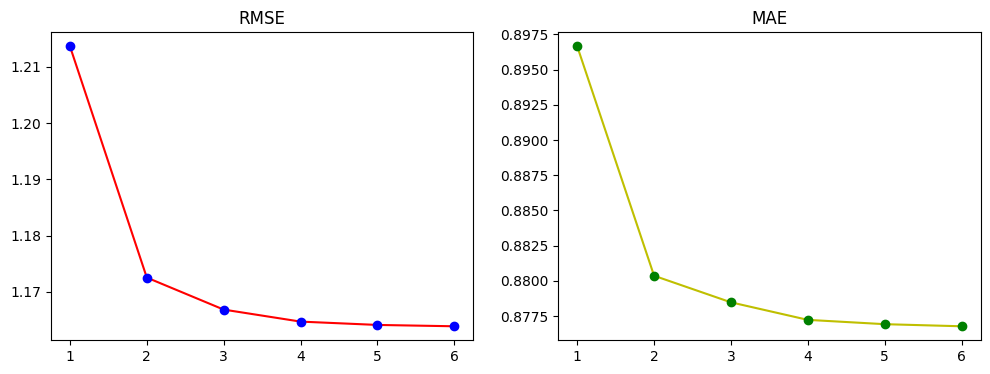

In [23]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(k_values, rmse_values, 'r-')
ax[0].plot(k_values, rmse_values, 'bo')
ax[0].set_title('RMSE')

ax[1].plot(k_values, mae_values, 'y-')
ax[1].plot(k_values, mae_values, 'go')
ax[1].set_title('MAE')

plt.show()

Optaremos por un k=3.

#### 2. Metricas con respecto al threshold.

In [24]:
#entrenamos nuestro modelo con k=3
modelo = KNNBasic(k=3, sim_options={'name': 'cosine', 'user_based': True})
modelo.fit(trainset)
predictions = modelo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [25]:
precision_scores = []
recall_scores = []
map_scores = []
ndcg_scores = []

k=10
for i in range(1, 6):

  precision_scores.append(precision_at_k(predictions, k, i))
  recall_scores.append(recall_at_k(predictions, k, i))
  map_scores.append(mean_average_precision_at_k(predictions, k, i))
  ndcg_scores.append(ndcg_at_k(predictions, k, i))

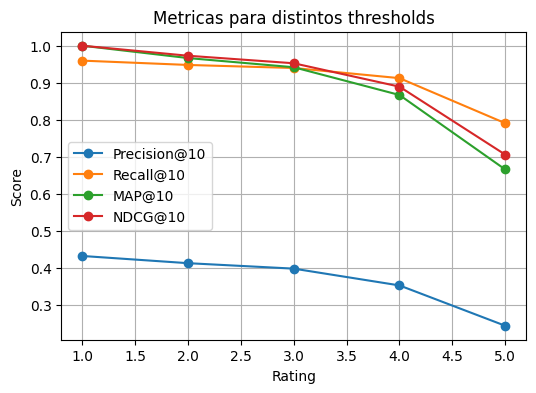

In [26]:
ks = range(1, 6)

plt.figure(figsize=(6, 4))
plt.plot(ks, precision_scores, label='Precision@10', marker='o')
plt.plot(ks, recall_scores, label='Recall@10', marker='o')
plt.plot(ks, map_scores, label='MAP@10', marker='o')
plt.plot(ks, ndcg_scores, label='NDCG@10', marker='o')

plt.xlabel('Rating')
plt.ylabel('Score')
plt.title('Metricas para distintos thresholds')
plt.legend()
plt.grid(True)
plt.show()

## ItemKNN

#### 1. Cantidad maxima de vecinos k para considerar.

In [27]:
k_values = [1, 2, 3, 4, 5, 6]
mae_values = []
rmse_values = []

#cambia el parametro 'user_based'
for k in k_values:
  modelo = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False})
  modelo.fit(trainset)
  predictions = modelo.test(testset)
  rmse_values.append(accuracy.rmse(predictions, verbose=False))
  mae_values.append(accuracy.mae(predictions, verbose=False))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: [1.1368580411142857, 1.1093194310467205, 1.1050425477977504, 1.1036224328820323, 1.103000061720526, 1.102808253249805]
MAE: [0.8153190522934997, 0.8067505145022275, 0.805214960680416, 0.8042587181202574, 0.8038060159670228, 0.8036006670327105]


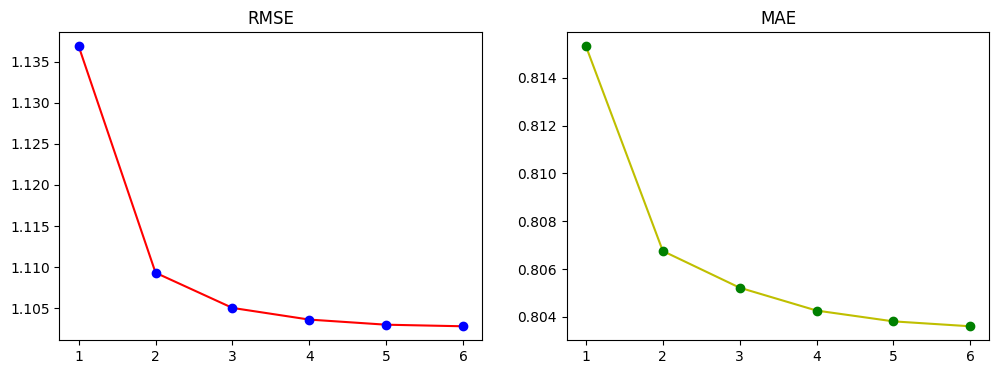

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(k_values, rmse_values, 'r-')
ax[0].plot(k_values, rmse_values, 'bo')
ax[0].set_title('RMSE')

ax[1].plot(k_values, mae_values, 'y-')
ax[1].plot(k_values, mae_values, 'go')
ax[1].set_title('MAE')

plt.show()

Optamos por k=3.

#### 2. Metricas con respecto al threshold.

In [29]:
#entrenamos el modelo con k=3
modelo = KNNBasic(k=3, sim_options={'name': 'cosine', 'user_based': False})
modelo.fit(trainset)
predictions = modelo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [30]:
precision_scores = []
recall_scores = []
map_scores = []
ndcg_scores = []

k=10
for i in range(1, 6):

  precision_scores.append(precision_at_k(predictions, k, i))
  recall_scores.append(recall_at_k(predictions, k, i))
  map_scores.append(mean_average_precision_at_k(predictions, k, i))
  ndcg_scores.append(ndcg_at_k(predictions, k, i))

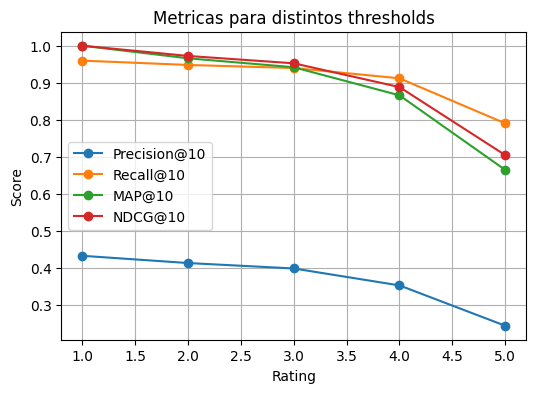

In [31]:
ks = range(1, 6)

plt.figure(figsize=(6, 4))
plt.plot(ks, precision_scores, label='Precision@10', marker='o')
plt.plot(ks, recall_scores, label='Recall@10', marker='o')
plt.plot(ks, map_scores, label='MAP@10', marker='o')
plt.plot(ks, ndcg_scores, label='NDCG@10', marker='o')

plt.xlabel('Rating')
plt.ylabel('Score')
plt.title('Metricas para distintos thresholds')
plt.legend()
plt.grid(True)
plt.show()

En base a al RMSE y el MAE, optaremos por usar el modelo basado en items, ya que con k=3 obtiene mejores estimaciones.

- UserKNN:
RMSE = 1.166864485026699,
MAE = 0.8784689227282821

- ItemKNN:
RMSE = 1.1050425477977504,
MAE = 0.805214960680416

# Recomendacion

In [32]:
#optamos por el itemknn para hacer la recomendacion
algo_itemknn = KNNBasic(k=3, sim_options={'name': 'cosine', 'user_based': False})
algo_itemknn.fit(trainset)
predictions = modelo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
# el top 20 bayesiano nos servira si el usuario no tiene informacion necesaria como para hacerle una recomendacion
top_20_bayesiano = metadata.sort_values(by='rating_bayesiano', ascending=False).head(20)
#los ids de los restaurantes se utilizaran para la funcion
gmap_ids = metadata['gmap_id'].unique()

In [34]:
#es importante pasar el dataset de metadata a un geodataframe para usar las coordenadas eficientemente
metadata = gpd.GeoDataFrame(
    metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="EPSG:4326"
)

Funcion de recomendacion de top n restaurantes.
- user_id: La id del usuario.
- n: La cantidad de restaurantes recomendados.
- threshold: El rating estimado minimo para considerar una recomendacion buena.

In [35]:
def top_n_recommendations_item(user_id, n, threshold):
    try:
        #verificar si el usuario está en el conjunto de entrenamiento
        inner_user_id = trainset.to_inner_uid(user_id)

        #filtrar los restaurantes que el usuario ya califico (recomendar restaurantes nuevos)
        user_rated_gmap_ids = samp[samp['user_id'] == user_id]['gmap_id'].unique()
        candidates = [gmap_id for gmap_id in gmap_ids if gmap_id not in user_rated_gmap_ids]

        predictions = [algo_itemknn.predict(user_id, gmap_id) for gmap_id in candidates] #predecir las calificaciones para los candidatos

        valid_predictions = [pred for pred in predictions if not pred.details['was_impossible']] #filtrar predicciones imposibles
        if len(valid_predictions) == 0:
            return top_20_bayesiano.head(n)[['name', 'gmap_id']] #si todas las predicciones fueron imposibles, entonces se devuelve el top de restaurantes

        predictions_k = [x for x in valid_predictions if x.est >= threshold] #filtrar las predicciones que son mayores al threshold
        top_n_predictions = sorted(predictions_k, key=lambda x: (x.details['actual_k'], x.est), reverse=True)[:n] #ordenamos por est y por k
        top_n_gmap_ids = [pred.iid for pred in top_n_predictions] #obtener los ids de los mejores n restaurantes recomendados

        #se devuelven los restaurantes y tambien se devuelven las predicciones en crudo para poder estudiarlas
        return metadata[metadata['gmap_id'].isin(top_n_gmap_ids)], sorted(predictions_k, key=lambda x: (x.details['actual_k'], x.est), reverse=True)

    except ValueError:
        #si el usuario no esta en el conjunto de entrenamiento, se devuelven los top restaurantes
        return top_20_bayesiano.head(n)[['name', 'gmap_id']]

Para ir visualizando el proceso, elegimos un usuario practicamente al azar. Este es el usuario de id 110104426283076616192 y recomendaremos 50 restaurantes para ver como se distribuyen en el mapa, considerando un threshold de 4.

In [36]:
restaurantes, predicciones = top_n_recommendations_item(110104426283076616192, 50, 4)

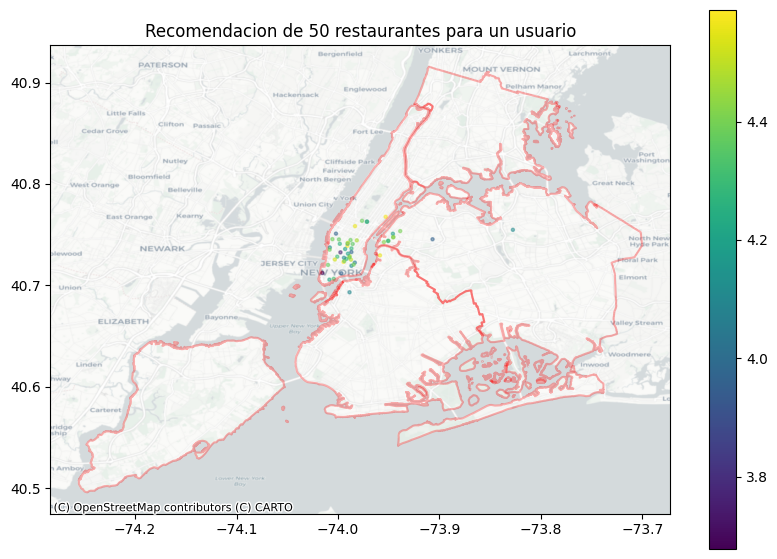

In [37]:
#se extraen los poligonos de la ciudad de Nueva York
shapefile_url = "https://data.cityofnewyork.us/api/geospatial/7t3b-ywvw?method=export&format=Shapefile"
boroughs = gpd.read_file(shapefile_url)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
restaurantes.plot(column='rating_bayesiano', legend=True, ax=ax, markersize=5, alpha=0.5)
boroughs.boundary.plot(ax=ax, color='red', alpha=0.3)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.title('Recomendacion de 50 restaurantes para un usuario')
plt.show()

Como vemos, el modelo puede que haya recomendado los mejores restaurantes para el usuario en base a su comportamiento, pero no estamos considerando que estos restaurantes estan bastante separados y no vendrian siendo la mejor opcion para un usuario que quiera recomendaciones cercanas, lo cual consideramos que seria la mayoria de las personas.

## Clustering

Para abordar el problema de la separacion de los restaurantes, haremos la implementacion de clustering para poder categorizar estos restaurantes considerando sus ubicaciones geoespaciales.

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from surprise.model_selection import train_test_split

In [39]:
#obtendremos el sample de los restaurantes que han sido rateados por los usuarios presentes en nuestro sample original de 16000 usuarios
ids = samp['gmap_id'].unique()
samp_rest = metadata[metadata['gmap_id'].isin(ids)]

#haremos un one-hot encoding de las categorias de los restaurantes para considerarlas en nuestro clustering
samp_rest.loc[:, ['category']] = samp_rest['category'].apply(lambda x: ', '.join(x))
categories = samp_rest['category'].str.get_dummies(sep=', ')
metadata_expanded = pd.concat([samp_rest.drop('category', axis=1), categories], axis=1)

In [40]:
metadata_expanded.shape

(18552, 614)

El one-hot encoding hace que aumente considerablemente la dimension del dataset ya que teniamos 606 categorias distintas. Para simplificar y optimizar el proceso de clustering, haremos uso del metodo PCA para reducir la dimensionalidad de los datos.

### PCA

Para hacer el PCA tenemos que normalizar los datos y asi evitamos sesgos.

In [41]:
#seleccionamos las columnas de tipo numerico para el PCA
columns_to_use = [col for col in metadata_expanded.columns if metadata_expanded[col].dtype in [np.float64, np.int64]]

#seleccionamos las columnas a normalizar
col_norm = ['latitude',
'longitude',
'avg_rating',
'num_of_reviews',
'rating_bayesiano',]

#usaremos el standard scaler
scaler = StandardScaler()

#normalizacion
metadata_expanded[col_norm] = scaler.fit_transform(metadata_expanded[col_norm])

In [42]:
#funcion para revisar la cantidad de componentes para mantener cierta varianza
def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

In [43]:
from sklearn.decomposition import PCA

X = metadata_expanded[columns_to_use]
n_componentes = X.shape[1] #la dimensionalidad de X (cant columnas)

pca = PCA(n_components=n_componentes)
pca.fit(X)

PCA(n_components=611)

In [44]:
#reduccion de dimension manteniendo un 95% de la varianza
componentes = min_var(0.95, pca.explained_variance_ratio_)
componentes

79

In [45]:
#la cantidad de componentes baja de 611 a 79
pca = PCA(n_components=componentes)
X_ = pca.fit_transform(X)

##### Tenemos que definir cuantos clusters queremos.
Podemos hacer uso del metodo del codo para obtener el numero optimo.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Metodo del codo para determinar numero optimo de clusters')

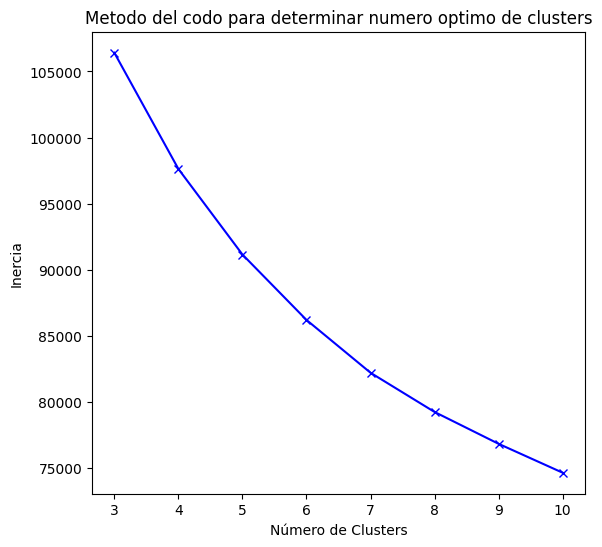

In [46]:
inertia = []
K = [3, 4, 5, 6, 7, 8, 9, 10]
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Numero de Clusters')
plt.ylabel('Inercia')
plt.title('Metodo del codo para determinar numero optimo de clusters')

En base a este grafico, es dificil determinar que numero es optimo para la cantidad de clusters, asi que partiremos con un numero razonable k=7.

In [68]:
kmeans_restaurants = KMeans(n_clusters=7, random_state=42)
metadata_expanded['restaurant_cluster'] = kmeans_restaurants.fit_predict(X_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'Cantidad de restaurantes')

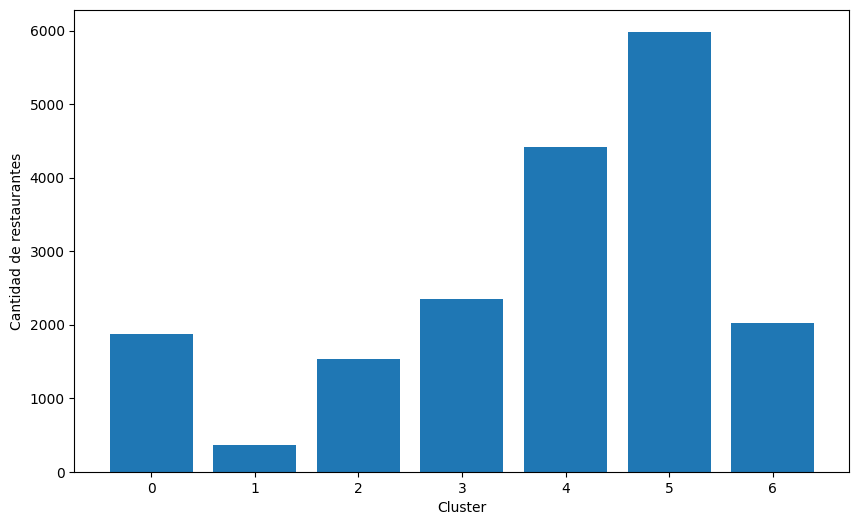

In [69]:
#veremos conmo se distribuyen los restaurantes en nuestros clusters
clusters = metadata_expanded['restaurant_cluster'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(clusters.index, clusters.values)
plt.xlabel('Cluster')
plt.ylabel('Cantidad de restaurantes')

Como se puede ver, hay clusters que tienen una considerable cantidad de restaurantes en comparacion con otros. En especifico el cluster 4 y 5. Para esto vamos a realizar una sub-clusterizacion de estos para balancear las clases.

In [70]:
#top 2 clusters
large_clusters = metadata_expanded['restaurant_cluster'].value_counts().head(2).index.tolist()
new_cluster_label = metadata_expanded['restaurant_cluster'].max() + 1  #se empiezan los nuevos labels desde el maximo existente

for cluster in large_clusters:
    cluster_data = metadata_expanded[metadata_expanded['restaurant_cluster'] == cluster]

    sub_kmeans = KMeans(n_clusters=3, random_state=42)  #kmeans a cada cluster con 3 sub clusters
    sub_clusters = sub_kmeans.fit_predict(cluster_data[['latitude', 'longitude']]) #aplicamos clustering en base a las coordenadas esta vez

    #actualizar labels
    for sub_cluster_label in np.unique(sub_clusters):
        if sub_cluster_label == 0:
            continue
        sub_cluster_indices = cluster_data.index[sub_clusters == sub_cluster_label]
        metadata_expanded.loc[sub_cluster_indices, 'restaurant_cluster'] = new_cluster_label
        new_cluster_label += 1

#nuevo dataframe con los labels de clusters
metadata_clusters = metadata_expanded.drop(columns=['sub_cluster'], errors='ignore')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
metadata_clusters['restaurant_cluster'].value_counts()

restaurant_cluster
7     3114
3     2352
6     2017
0     1879
9     1847
4     1736
8     1543
2     1532
5     1328
10     838
1      366
Name: count, dtype: int64

Text(0, 0.5, 'Cantidad de restaurantes')

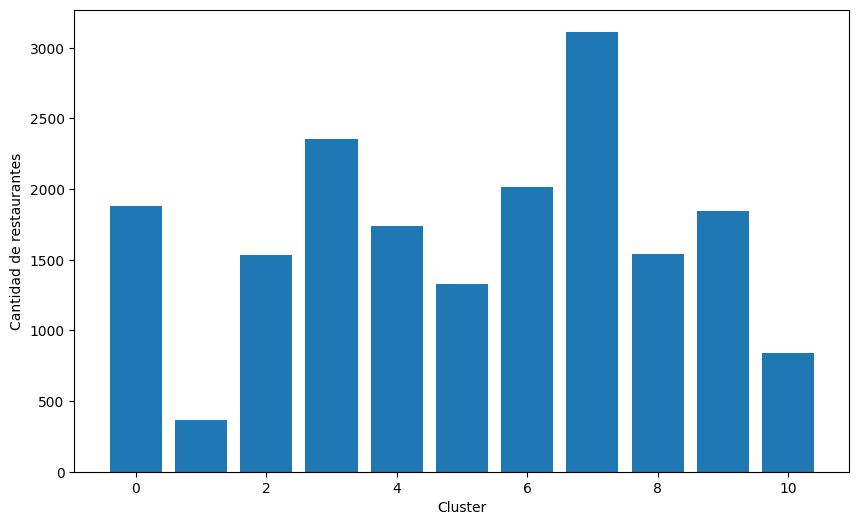

In [72]:
#veremos conmo se distribuyen los restaurantes en nuestros clusters
clusters = metadata_clusters['restaurant_cluster'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(clusters.index, clusters.values)
plt.xlabel('Cluster')
plt.ylabel('Cantidad de restaurantes')

Ahora podemos decir que se distribuyen mejor y eventualmente evitaremos sesgos mayores para la clasificacion.

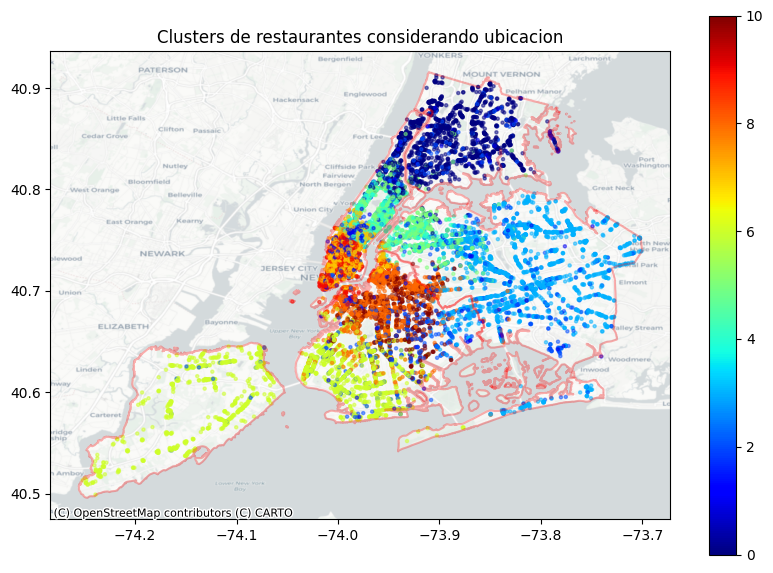

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
metadata_clusters.plot(column='restaurant_cluster', legend=True, ax=ax, markersize=5, alpha=0.5, cmap=plt.get_cmap('jet'))
boroughs.boundary.plot(ax=ax, color='red', alpha=0.3)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.title('Clusters de restaurantes considerando ubicacion')
plt.show()

Tambien seria util hacer una visualizacion PCA para ver como se agrupan los clusters fuera de un mapa.

In [132]:
pca_X = PCA(n_components=2)
X_2 = pca_X.fit_transform(X_)

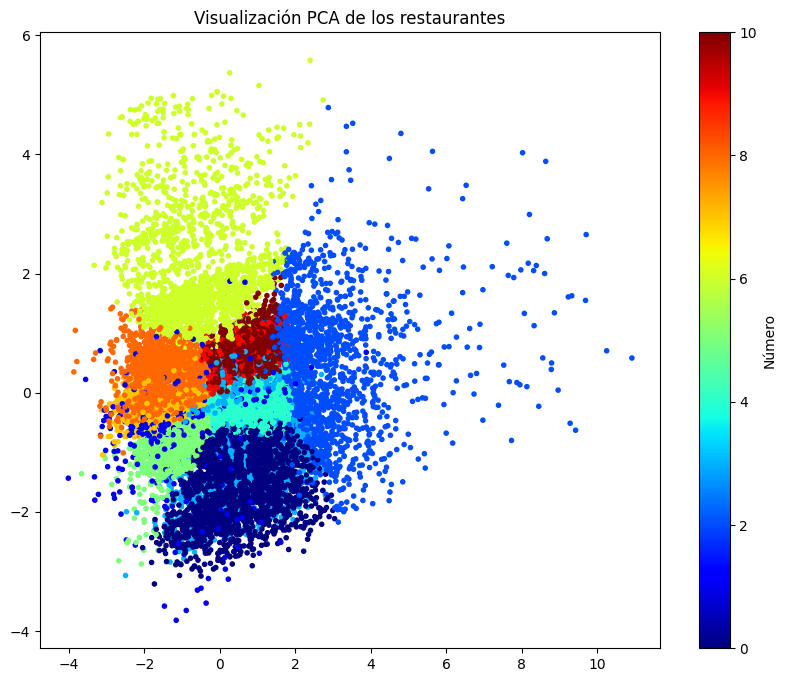

In [133]:
plt.figure(figsize=(10, 8))
plt.scatter(X_2[:, 0], X_2[:, 1], c=metadata_expanded['restaurant_cluster'], cmap=plt.get_cmap('jet'), marker='.')
plt.colorbar(label='Número')
plt.title('Visualización PCA de los restaurantes')
plt.show()

Se notan los mismos clusters "perifericos" que encontrabamos en el mapa bien separados del resto y tambien las mezcla de clusters mas al centro lo cual representa en este caso los clusters que se ven en el area de Manhattan en el mapa.

### Recomendacion considerando clusters.

Funcion de recomendacion de top n restaurantes.
- user_id: La id del usuario.
- n: La cantidad de restaurantes recomendados.
- threshold: El rating estimado minimo para considerar una recomendacion buena.
- user_cluster: Es el cluster predominante en los restaurantes que ha visitado el usuario.

In [96]:
#el proceso de recomendacion con clusters sera igual al proceso normal definido anteriormente, solamente que se agrega una linea de codigo para filtrar por cluster
def top_n_recommendations_item_cluster(user_id, n, threshold, user_cluster):
    try:
        inner_user_id = trainset.to_inner_uid(user_id)
        user_rated_gmap_ids = samp[samp['user_id'] == user_id]['gmap_id'].unique()
        candidates = [gmap_id for gmap_id in gmap_ids if gmap_id not in user_rated_gmap_ids]
        predictions = [algo_itemknn.predict(user_id, gmap_id) for gmap_id in candidates]
        valid_predictions = [pred for pred in predictions if not pred.details['was_impossible']]
        if len(valid_predictions) == 0:
            return top_20_bayesiano.head(n)[['name', 'gmap_id']]

        predictions_k = [x for x in valid_predictions if x.est >= threshold]

        #--------------------------------------------------------------------------------------------
        #se agrega una filtracion mas donde se filtra en base al user_cluster
        predictions_k_cluster = [rec for rec in predictions_k if metadata_clusters[metadata_clusters['gmap_id'] == rec.iid]['restaurant_cluster'].values[0] == user_cluster]
        #---------------------------------------------------------------------------------------------

        top_n_predictions = sorted(predictions_k_cluster, key=lambda x: (x.details['actual_k'], x.est), reverse=True)[:n]
        top_n_gmap_ids = [pred.iid for pred in top_n_predictions]
        return metadata_clusters[metadata_clusters['gmap_id'].isin(top_n_gmap_ids)], sorted(predictions_k_cluster, key=lambda x: (x.details['actual_k'], x.est), reverse=True)

    except ValueError:
        return top_20_bayesiano.head(n)[['name', 'gmap_id']]

Se define la funcion que asignara el cluster predominante para cada usuario.

In [78]:
df_interactions = samp[['user_id', 'gmap_id', 'rating']]

def get_user_cluster(user_id, df_interactions, df_restaurants):
    #se filtran por los restaurantes del usuario y se obtienen los clusters
    user_rated_restaurants = df_interactions[df_interactions['user_id'] == user_id]['gmap_id']
    user_clusters = df_restaurants[df_restaurants['gmap_id'].isin(user_rated_restaurants)]['restaurant_cluster']
    return user_clusters.mode()[0] #devuelte top 1

In [89]:
#seguiremos usando el usuario 110104426283076616192 para comparar con el resultado anterior
user_cluster = get_user_cluster(110104426283076616192, df_interactions, metadata_clusters)

In [99]:
#obtenemos la recomendacion
restaurantes, predicciones = top_n_recommendations_item_cluster(110104426283076616192, 50, 4, user_cluster)

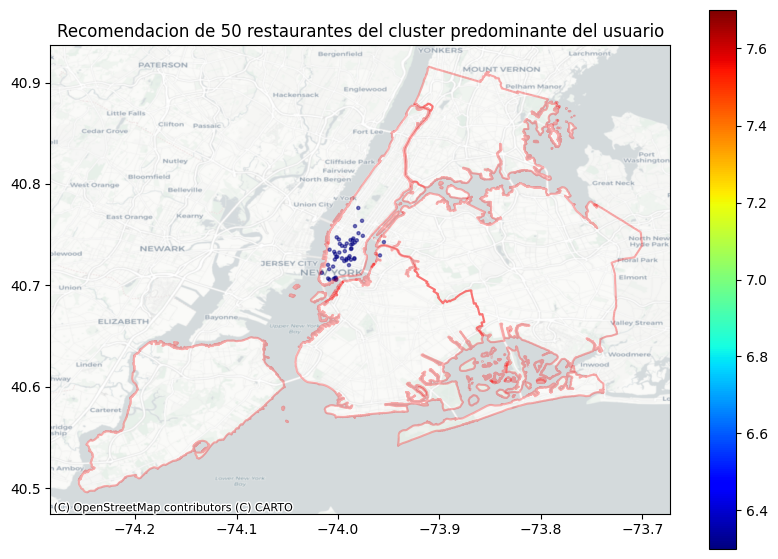

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
restaurantes.plot(column='restaurant_cluster', legend=True, ax=ax, markersize=5, alpha=0.5, cmap=plt.get_cmap('jet'))
boroughs.boundary.plot(ax=ax, color='red', alpha=0.3)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.title('Recomendacion de 50 restaurantes del cluster predominante del usuario')
plt.show()

Se puede ver como los restaurantes ahora estan presentes en un are mucho mas concentrada, lo cual implica una mejor recomendacion en el aspecto de ubicacion. Aun asi siguen estando algo separados considerando que la ciudad es bien grande.

### Recomendacion en un area.
Finalmente vamos a considerar y prioritizar la ubicacion en la que se encuentra un usuario. Nuestros datos no cuentan con esta informacion ya que vendria siendo un dato dinamico. Para esto haremos una simulacion, generando un punto random en el mapa y asignandole los datos de un usuario en particular para hacer la recomendacion.

In [105]:
#funcion para generar un punto random dentro de uno de los poligonos de la ciudad
from shapely.geometry import Point

def generate_random_point_within_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(p):
            return p

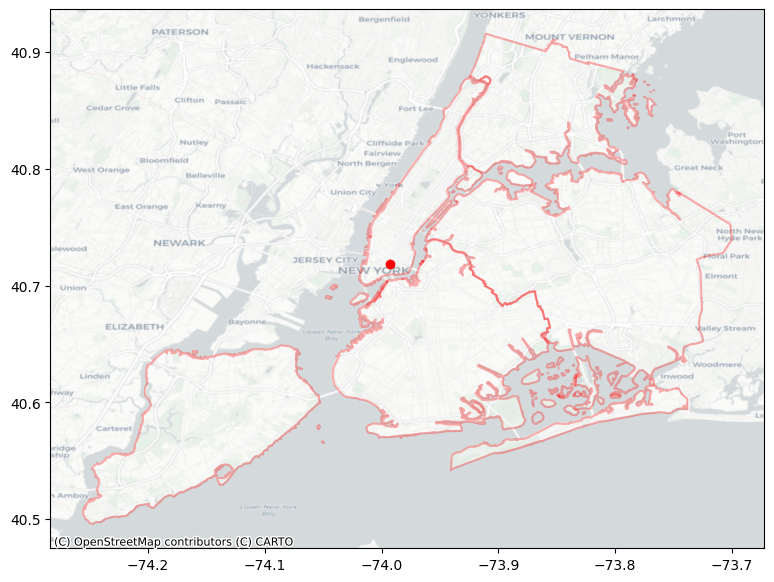

In [109]:
#seleccionaremos el poligono de la isla central (se puede randomizar)
selected_borough = boroughs.loc[2]

np.random.seed(1000) #seed para replicar resultados
#se obtiene la ubicacion aleatoria dentro del borough seleccionado
random_point = generate_random_point_within_polygon(selected_borough.geometry)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(random_point.x, random_point.y, 'ro')
boroughs.boundary.plot(ax=ax, color='red', alpha=0.3)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.show()

In [110]:
#necesitaremos una funcion para calcular las distancias en km
from math import radians, cos, sin, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  #radio de la Tierra en km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [114]:
#se creara un dataframe auxiliar para revisar las distancias desde el punto hacia los restaurantes
df_dist = pd.DataFrame()
df_dist['gmap_id'] = samp_rest['gmap_id']
df_dist['distance'] = samp_rest.apply(lambda row: haversine_distance(row['latitude'], row['longitude'], random_point.y, random_point.x), axis=1)

Funcion de recomendacion de top n restaurantes en un area.
- user_id: La id del usuario.
- n: La cantidad de restaurantes recomendados.
- threshold: El rating estimado minimo para considerar una recomendacion buena.
- radio: El radio en km del circulo que filtrara los restaurantes recomendados.

In [119]:
#nuevamente nos encontramos con una funcion muy similar a la primera de recomendacion
#solamente que se filtran los restaurantes que no estan dentro del area antes de recomendar.
def top_n_recommendations_item_radio(user_id, n, threshold, radio):
    try:
        inner_user_id = trainset.to_inner_uid(user_id)
        user_rated_gmap_ids = samp[samp['user_id'] == user_id]['gmap_id'].unique()

        #-----------------------------------------------------------------------------------
        #se filtran los restaurantes que no estan dentro del radio
        df_distancias = df_dist[df_dist['distance'] <= radio]
        gmap_ids = df_distancias['gmap_id'].unique()
        #-----------------------------------------------------------------------------------

        candidates = [gmap_id for gmap_id in gmap_ids if gmap_id not in user_rated_gmap_ids]
        predictions = [algo_itemknn.predict(user_id, gmap_id) for gmap_id in candidates]
        valid_predictions = [pred for pred in predictions if not pred.details['was_impossible']]

        if len(valid_predictions) == 0:
            return top_20_bayesiano.head(n)[['name', 'gmap_id']]
        predictions_k = [x for x in valid_predictions if x.est >= threshold]
        top_n_predictions = sorted(predictions_k, key=lambda x: (x.details['actual_k'], x.est), reverse=True)[:n]
        top_n_gmap_ids = [pred.iid for pred in top_n_predictions]
        return metadata_clusters[metadata_clusters['gmap_id'].isin(top_n_gmap_ids)], sorted(predictions_k, key=lambda x: (x.details['actual_k'], x.est), reverse=True)

    except ValueError:
        return top_20_bayesiano.head(n)[['name', 'gmap_id']]

In [120]:
#recomendamos en base al mismo usuario de los otros ejemplos
restaurantes, predicciones = top_n_recommendations_item_radio(110104426283076616192, 50, 4, 1) #probaremos con un radio de 1 kilometro

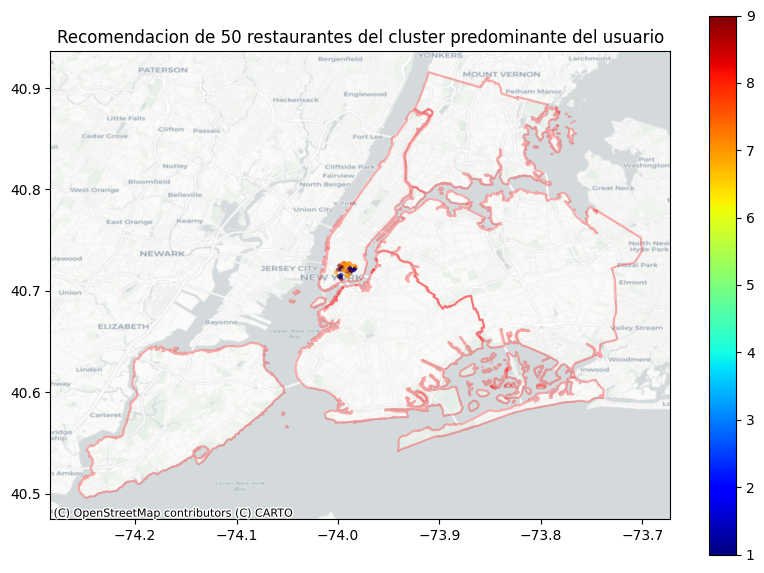

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
restaurantes.plot(column='restaurant_cluster', legend=True, ax=ax, markersize=5, alpha=0.5, cmap=plt.get_cmap('jet'))
boroughs.boundary.plot(ax=ax, color='red', alpha=0.3)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.title('Recomendacion de 50 restaurantes dentro de un area de radio 1 km')
plt.show()

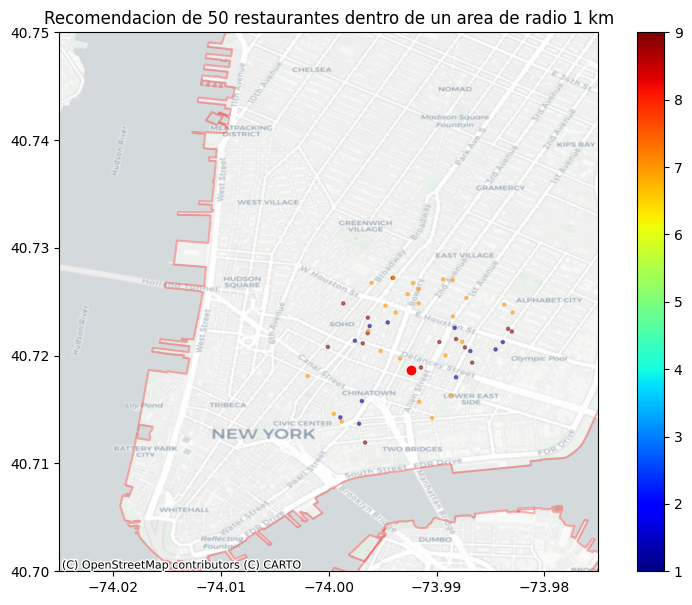

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
restaurantes.plot(column='restaurant_cluster', legend=True, ax=ax, markersize=5, alpha=0.5, cmap=plt.get_cmap('jet'))
boroughs.boundary.plot(ax=ax, color='red', alpha=0.3)
ax.set_xlim(-74.025, -73.975)
ax.set_ylim(40.7, 40.75)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.plot(random_point.x, random_point.y, 'ro')
plt.title('Recomendacion de 50 restaurantes dentro de un area de radio 1 km')
plt.show()

Ahora obtuvimos una recomendacion mas util en una situacion "real" donde un usuario quisiera tener recomendaciones cercanas. El radio se puede ajustar a gusto y la cantidad de restaurantes tambien.